In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Dense, Input, Concatenate, Reshape, Lambda
from keras.utils import plot_model
from scipy import stats as ss
from IPython.core.display import Image

Using TensorFlow backend.


In [2]:
def create_model(n_samples, kernel_size):
    # Ratio should be 0 < x < 1, add check later on.
    # Model parameters:
    N_DENSE_1 = 10  # Other parameters don't depend on this one.
    N_DENSE_2 = 40 
    
    N_IN_DENSE = int(np.ceil((n_samples + kernel_size) / N_DENSE_2))
    N_LEN = N_IN_DENSE * N_DENSE_2
    KERNEL_SIZE = N_LEN - n_samples + 1

    print("N_DENSE_1:", N_DENSE_1, "\nN_DENSE_2:", N_DENSE_2, "\nN_IN_DENSE:",
          N_IN_DENSE, "\nN_LEN:", N_LEN, "\nKERNEL_SIZE:", KERNEL_SIZE)
    
    model = Input(shape=(1,), name='input')
    print("Shape after input:", model.shape)
    
    layer_1 = []
    layer_2 = []
    
    for i in range(N_IN_DENSE): # N_IN_DENSE * N_DENSE_2 - kernel_size of conv = n_samples
        layer_1.append(Dense(N_DENSE_1, activation='relu', name='layer_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(N_DENSE_2, activation='relu', name='layer_2_{:02d}'.format(i))(layer_1[-1]))
    
    concat = Concatenate()(layer_2)
    print("Shape after concat:", concat.shape)
    
    reshape = Reshape(target_shape=(N_LEN, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    # A higher number of filters eliminates the plateau.
    conv = Conv1D(filters=15, kernel_size=KERNEL_SIZE, strides=1)(reshape)
    print("Kernel size:", KERNEL_SIZE)
    print("Shape after conv1d:", conv.shape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    return model

In [3]:
# Parameters to set.
N_DATA = 10000  # Number of parameter samples
N_SAMPLES = 100  # Number of data samples

# Parameter-specific settings.
MIN_MU, MAX_MU = -3, 3
MIN_X, MAX_X = -10, 10

In [4]:
# Generate spaces.
mu = np.linspace(MIN_MU, MAX_MU, N_DATA)
x = np.linspace(MIN_X, MAX_X, N_SAMPLES)

# Transform mu to match input format.
mu = mu[:, np.newaxis]

# Sample from standard normal distribution.
x_sampled = ss.norm(mu).logpdf(x[np.newaxis, :])

In [5]:
model = create_model(N_SAMPLES, 100)

model.compile(optimizer='adam',
              loss='mean_squared_error')

# What is an acceptable time for fitting?
model.fit(mu, x_sampled, shuffle=True, batch_size=25, epochs=25)

N_DENSE_1: 10 
N_DENSE_2: 40 
N_IN_DENSE: 5 
N_LEN: 200 
KERNEL_SIZE: 101
Shape after input: (?, 1)
Instructions for updating:
Colocations handled automatically by placer.
Shape after concat: (?, 200)
Shape after reshape: (?, 200, 1)
Kernel size: 101
Shape after conv1d: (?, 100, 15)
Shape after avg: (?, 100)
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
10000/10000 [==============================] - 2s 204us/step - loss: 140.7023
Epoch 2/25
10000/10000 [==============================] - 2s 151us/step - loss: 2.3291
Epoch 3/25
10000/10000 [==============================] - 2s 154us/step - loss: 0.4101
Epoch 4/25
10000/10000 [==============================] - 1s 148us/step - loss: 0.1771
Epoch 5/25
10000/10000 [==============================] - 2s 165us/step - loss: 0.1030
Epoch 6/25
10000/10000 [==============================] - 2s 165us/step - loss: 0.0674
Epoch 7/25
10000/10000 [==============================] - 2s 172us/step - loss: 0.0454
Epoch 8/25
10000/10000 [=======

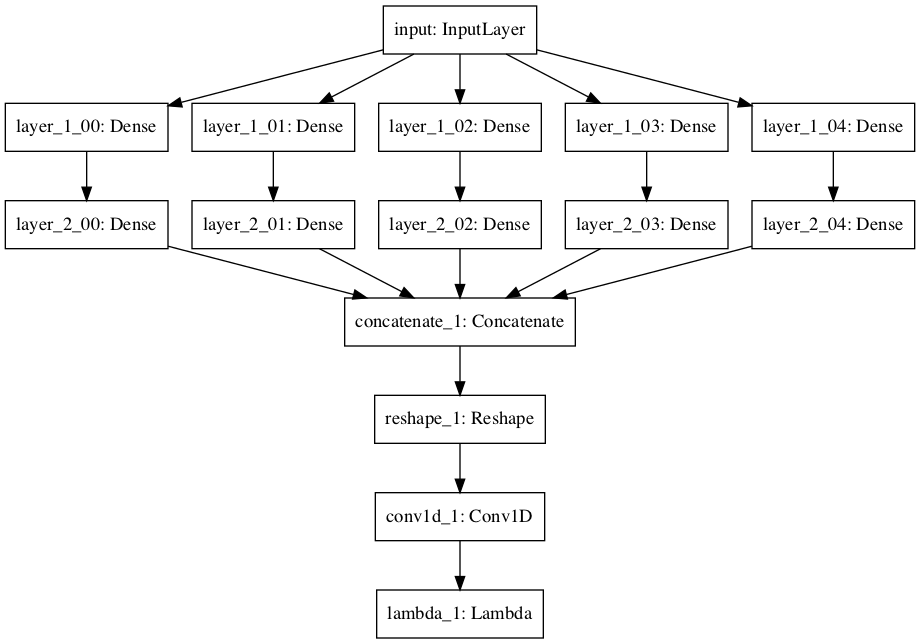

In [6]:
plot_model(model, to_file='model.png')
Image(retina=True, filename='model.png')

In [7]:
predictions = model.predict(mu)

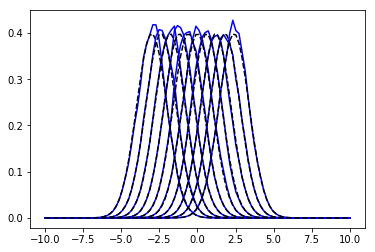

In [8]:
for ix in np.linspace(0, 9000, 10, dtype=int):
    plt.plot(x, np.exp(predictions[ix, :]), c='blue')
    plt.plot(x, np.exp(x_sampled[ix, :]), c='k', ls='--')
    mu[ix]

In [9]:
from scipy.interpolate import griddata

This is a likelihood function using the DNN model

In [10]:
def log_likelihood(keras_model,
               mu,
               data,
               x=x):
    
    if (mu < -3) or (mu > 3):
        return -1e9
    mu = np.atleast_1d(mu)
    likelihood_on_grid = model.predict(mu).T
    
    x = np.atleast_2d(x).T

    ll = griddata(x, likelihood_on_grid, data, fill_value=-1e9)
    
    return ll
    

Let's check if it works

In [11]:
import scipy.stats as ss

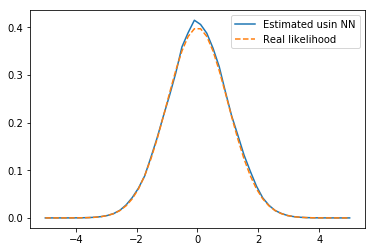

In [12]:
x_test = np.linspace(-5, 5)
ll = log_likelihood(model,
           0,
           x_test)
    
plt.plot(x_test, np.exp(ll), label='Estimated usin NN')
plt.plot(x_test, ss.norm().pdf(x_test), ls='--', label='Real likelihood')
plt.legend()

Awesome!

Now let's optimize

In [13]:
from scipy import optimize

In [14]:
def get_summed_ll(model, data, mu):
    return np.sum(log_likelihood(model, mu, data))

In [15]:
def estimate_mu(data,
                keras_model=model,
                lim=(-3, 3)):
    
    
    return optimize.minimize(lambda x: -get_summed_ll(keras_model, 
                                                      data, x[0]), 
                      x0=[0], 
                      method='Nelder-Mead').x[0]
    
    

In [16]:
test_data = ss.norm(2.5).rvs(100)

In [17]:
estimate_mu(test_data)

2.2618750000000025

In [18]:
r = optimize.minimize(lambda x: -get_summed_ll(model, test_data, x), method='Nelder-Mead', x0=np.array([0]), bounds=[(-3, 3)])

/Users/gilles/miniconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:517: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


In [19]:
from itertools import product

In [20]:
import pandas as pd

In [21]:
from tqdm import tqdm_notebook as tqdm

In [27]:
df = []

n_ns = 10
n_mus = 10
n_runs = 5

pars = product(np.linspace(5, 100, n_ns, dtype=int), np.linspace(-3, 3, n_mus), np.arange(n_runs))

with tqdm(total=n_ns*n_mus*n_runs) as t:
    for n, mu, trial in pars:

        test_data = ss.norm(loc=mu).rvs(n)

        nn_estimate = estimate_mu(test_data)
        ml_estimate = np.mean(test_data)

        df.append({'n':n,
                   'mu':mu,
                   'trial':trial,
                   'nn_estimate':nn_estimate,
                   'ml_estimate':ml_estimate})
        t.update()
    
df = pd.DataFrame(df)

In [28]:
df.head()

,ml_estimate,mu,n,nn_estimate,trial
0,-2.845943,-3.0,5,-2.900875,0
1,-2.263331,-3.0,5,-2.287563,1
2,-2.144839,-3.0,5,-2.287563,2
3,-2.843751,-3.0,5,-2.904313,3
4,-3.097881,-3.0,5,-2.999875,4


In [29]:
import seaborn as sns

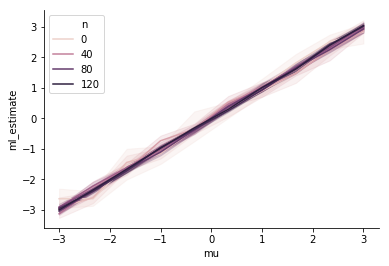

In [40]:
sns.lineplot('mu', 'ml_estimate', 'n', data=df)
sns.despine()

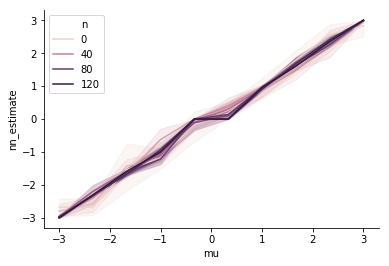

In [39]:
sns.lineplot('mu', 'nn_estimate', 'n', data=df)
sns.despine()

In [47]:
df_ = df.melt(id_vars=['mu', 'n', 'trial'], var_name='method', value_name='estimate')

In [48]:
df_.head()

,mu,n,trial,method,estimate
0,-3.0,5,0,ml_estimate,-2.845943
1,-3.0,5,1,ml_estimate,-2.263331
2,-3.0,5,2,ml_estimate,-2.144839
3,-3.0,5,3,ml_estimate,-2.843751
4,-3.0,5,4,ml_estimate,-3.097881


In [52]:
tmp = df_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['mu'])[0]).to_frame('r')
tmp

r
n   method               
5   ml_estimate  0.975510
    nn_estimate  0.969730
15  ml_estimate  0.987048
    nn_estimate  0.986360
26  ml_estimate  0.991839
    nn_estimate  0.988753
36  ml_estimate  0.996146
    nn_estimate  0.995749
47  ml_estimate  0.997658
    nn_estimate  0.996705
57  ml_estimate  0.998154
    nn_estimate  0.994898
68  ml_estimate  0.998360
    nn_estimate  0.996199
78  ml_estimate  0.998228
    nn_estimate  0.995909
89  ml_estimate  0.998395
    nn_estimate  0.995525
100 ml_estimate  0.998604
    nn_estimate  0.995711

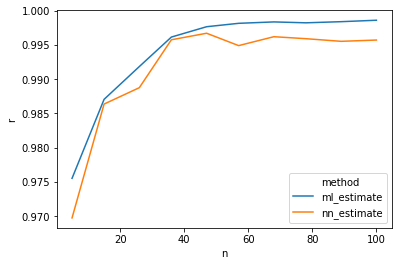

In [54]:
sns.lineplot('n', 'r', 'method', data=tmp.reset_index())